In [38]:
# Î™®Îìà Î∂àÎü¨Ïò§Í∏∞
from PIL import Image
import warnings
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import timm
from timm.data import resolve_data_config, create_transform
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, \
classification_report, roc_curve, precision_recall_curve, average_precision_score
import copy
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

## Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨

In [40]:
# csv ÏùΩÏñ¥Ïò§Í∏∞
warnings.simplefilter(action='ignore', category=pd.errors.DtypeWarning)
df = pd.read_csv('./data/Train_SNUH_CPA_90d_osteo_2class.csv', low_memory=False)
unique_pids = df['pid'].unique()

In [4]:
# Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï†
train_pids, temp_pids = train_test_split(unique_pids, test_size=0.2, random_state=42)
val_pids, test_pids = train_test_split(temp_pids, test_size=0.5, random_state=42)

In [5]:
# Îç∞Ïù¥ÌÑ∞ ÌîÑÎ†àÏûÑÌôî
df_train = df[df['pid'].isin(train_pids)].copy()
df_val = df[df['pid'].isin(val_pids)].copy()
df_test = df[df['pid'].isin(test_pids)].copy()

### Îç∞Ïù¥ÌÑ∞ÏÖã ÌÅ¥ÎûòÏä§

In [6]:
class CXRDataset(Dataset):
    def __init__(self, dataframe, base_path, transform=None):
        self.df = dataframe.reset_index(drop=True) #Ïñ¥Îñ§ dfÎ•º ÎÑ£Ïñ¥ÎèÑ Î¨∏Ï†úÏóÜÎèÑÎ°ù.
        self.base_path = base_path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx): # dataset loaderÏóêÏÑú ÌÖêÏÑúÌòïÌÉúÎ°ú Í∫ºÎÇº Ïàò ÏûàÎèÑÎ°ù Ï†ïÏùòÌï¥Ïïº Ìï®. 
        row = self.df.iloc[idx]
        img_path = os.path.join(self.base_path, row['fp'])
        image = Image.open(img_path).convert("L")
        if self.transform: # transform.compose()Í∞ùÏ≤¥Î•º Î∞õÏúºÎ©¥ Ìï¥Îãπ ÏûëÏóÖÎì§Ïù¥ Îì§Ïñ¥ ÏûàÏùå.
            image = self.transform(image)
        return image, float(row['label']) 

### Îç∞Ïù¥ÌÑ∞ÏÖã Î°úÎçî

In [7]:
IMG_SIZE = 256  # ÌïôÏäµ Ìï¥ÏÉÅÎèÑÏóê ÎßûÏ∂§

# ÌÜµÍ≥ÑÏö©(Ï¶ùÍ∞ïX, NormalizeX) transform
stats_tf = T.Compose([
    T.Resize(IMG_SIZE),
    T.CenterCrop(IMG_SIZE),   # ÏõêÎ≥∏ ÎπÑÏú®/ÌÅ¨Í∏∞Í∞Ä Ï†úÍ∞ÅÍ∞ÅÏù¥Î©¥ Ï∂îÏ≤ú, ÏïÑÎãàÎ©¥ ÏÉùÎûµ Í∞ÄÎä•
    T.ToTensor(),             # [0,1] Î≤îÏúÑ(float32), CxHxW
])

class CXRStatsDataset(Dataset):
    def __init__(self, dataframe, base_path, transform):
        self.df = dataframe.reset_index(drop=True)
        self.base_path = base_path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(os.path.join(self.base_path, row['fp'])).convert("L")
        img = self.transform(img)   # shape: (1, H, W), float32 in [0,1]
        return img


## Î™®Îç∏ Íµ¨Ï∂ï

In [8]:
# Î≥ÄÏàò ÏÑ†Ïñ∏
IMG_SIZE = 256 
mean = 0.5716567635536194
std = 0.24481500685214996

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
# timm DenseNet 161 model load and configuration
Dense161 = timm.create_model('densenet161', pretrained= True, in_chans=1, num_classes =1).to(device)
config = resolve_data_config({}, model=Dense161)
config.update({
    "input_size": (1, IMG_SIZE, IMG_SIZE),
    "mean": (mean,),
    "std": (std,)})

# Î™®Îç∏ Í∂åÏû• ÏÑ§Ï†ïÏúºÎ°ú transform Ï†ÅÏö©
transform = create_transform(**config)

model.safetensors:   0%|          | 0.00/116M [00:00<?, ?B/s]

#### transform Ï†ïÏùò

In [11]:
# ÌïôÏäµ(Train): ÏïΩÌïú Í∏∞Ìïò/Î™ÖÏïî Ï¶ùÍ∞ï, Flip X
train_tf = T.Compose([
    T.Resize(int(IMG_SIZE * 1.15)), # ÏÇ¥Ïßù ÌÅ¨Í≤å Î¶¨ÏÇ¨Ïù¥Ï¶à
    T.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0), ratio=(0.95, 1.05)),
    T.RandomRotation(degrees=5),                              
    T.RandomAffine(degrees=0, translate=(0.02, 0.02), scale=(0.98, 1.02)), # Ïù¥Îèô, scale
    T.ToTensor(),
    T.Normalize(mean, std),
    T.RandomErasing(p=0.25, scale=(0.01, 0.03), value=0.0, inplace=True),  # p%Ïùò ÏÉòÌîåÏóê ÎåÄÌï¥ scaleÎßåÌÅºÏùò ÎûúÎç§Ìïú ÏòÅÏó≠ÏùÑ value Í∞íÏúºÎ°ú Î≥ÄÌôò. 
])

# Í≤ÄÏ¶ù/ÌÖåÏä§Ìä∏(Eval): ÏùºÍ¥ÄÎêú Ï†ÑÏ≤òÎ¶¨Îßå (Î¶¨ÏÇ¨Ïù¥Ï¶à+ÏÑºÌÑ∞ÌÅ¨Î°≠+Ï†ïÍ∑úÌôî)
eval_tf = T.Compose([
    T.Resize(IMG_SIZE),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(mean, std),
])

#### Dataset ÏÉùÏÑ±

In [12]:
#timm beit Îç∞Ïù¥ÌÑ∞ÏÖã
base_path = './data/SNUH_CXR_png/SNUH_CXR_png'

train_dataset = CXRDataset(df_train, base_path, transform=train_tf)
val_dataset = CXRDataset(df_val, base_path, transform=eval_tf)
test_dataset = CXRDataset(df_test, base_path, transform=eval_tf)

In [13]:
BATCH_SIZE = 32 # 64ÏóêÏÑú 1.2Îßå MiB ÎÇ®Ïùå (28317MiB /  40960MiB) -> 90ÎèÑ Í∞ÄÎä•
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=12)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=12)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=False, pin_memory=True,num_workers=12)

## ÌïôÏäµ Î£®ÌîÑ

In [14]:
# pretrained net ÌïôÏäµ Î£®ÌîÑ
train_his_f1, train_his_acc, train_his_auc, train_his_loss = [], [], [], []
val_his_f1, val_his_acc, val_his_auc, val_his_loss = [], [], [], []

def train_loop(model, train_loader, val_loader, criterion, optimizer, device, epochs=20, patience=5, save_path="best_model.pt"):
    best_val_metric = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    counter = 0

    for epoch in range(epochs):
        print(f"\n[Epoch {epoch+1}]")

        # üîÅ TRAINING
        model.train()
        train_loss = 0
        train_preds, train_targets = [], []

        for images, labels in tqdm(train_loader):
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = torch.sigmoid(outputs).detach().cpu().numpy()
            train_preds.extend(preds)
            train_targets.extend(labels.cpu().numpy())

        avg_train_loss = train_loss / len(train_loader)
        train_preds = np.array(train_preds)
        train_targets = np.array(train_targets)
        train_preds_bin = (train_preds > 0.5).astype(int)

        train_auc = roc_auc_score(train_targets, train_preds)
        train_acc = accuracy_score(train_targets, train_preds_bin)
        train_f1 = f1_score(train_targets, train_preds_bin)
        # train_loss

        train_his_f1.append(train_f1)
        train_his_acc.append(train_acc)
        train_his_auc.append(train_auc)
        train_his_loss.append(avg_train_loss)
        
        print(f"‚úÖ Train | Loss: {avg_train_loss:.4f} | Acc: {train_acc:.4f} | AUC: {train_auc:.4f} | F1: {train_f1:.4f}")

        # üîé VALIDATION
        model.eval()
        val_loss = 0
        val_preds, val_targets = [], []

        with torch.no_grad():
            for images, labels in tqdm(val_loader):
                images = images.to(device)
                labels = labels.to(device).float().unsqueeze(1)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                preds = torch.sigmoid(outputs).cpu().numpy()
                val_preds.extend(preds)
                val_targets.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_preds = np.array(val_preds)
        val_targets = np.array(val_targets)
        val_preds_bin = (val_preds > 0.5).astype(int)

        val_auc = roc_auc_score(val_targets, val_preds)
        val_acc = accuracy_score(val_targets, val_preds_bin)
        val_f1 = f1_score(val_targets, val_preds_bin)
    

        val_his_f1.append(val_f1)
        val_his_acc.append(val_acc)
        val_his_auc.append(val_auc)
        val_his_loss.append(avg_val_loss)
        
        print(f"üîé Val   | Loss: {avg_val_loss:.4f} | Acc: {val_acc:.4f} | AUC: {val_auc:.4f} | F1: {val_f1:.4f}")

        # üõë EARLY STOPPING Í∏∞Ï§Ä: val_auc Í∏∞Ï§Ä -> f1ÏúºÎ°ú 
        if val_auc > best_val_metric:
            best_val_metric = val_auc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), save_path)
            print(f"‚úÖ Best model updated! (saved to {save_path})")
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("‚èπÔ∏è Early stopping triggered.")
                break

    # ÏµúÏ¢Ö best model Î°úÎìú
    model.load_state_dict(best_model_wts)

    return model

### Î™®Îç∏ Ï†ïÏùò

In [15]:
# focal loss

class BinaryFocalLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=2.0, reduction='mean'): # what is reduction?
        super(BinaryFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        print(logits.shape)
        probs = torch.sigmoid(logits)
        probs = probs.clamp(min=1e-6, max=1 - 1e-6) # min, maxÎ•º Ï¥àÍ≥ºÌïòÎäî Í∞íÎì§ÏùÑ Î≥¥Ï†ï

        targets = targets.view(-1,1).float() # maybe flattening
        print(targets.shape)
        pt = torch.where(targets == 1, probs, 1-probs) # contidtionÏùò BooleanÏóê Îî∞Îùº probs, 1-probs Ï§ë ÌïòÎÇòÎ•º ÏÑ†ÌÉù
        alpha_t = torch.where(targets == 1, self.alpha, 1-self.alpha) # ÌÅ¥ÎûòÏä§Ïóê Îî∞Îùº Í∞ÄÏ§ëÏπò alpha_t Î∂ÄÏó¨

        focal_weight = alpha_t * (1-pt) ** self.gamma
        loss = -focal_weight*torch.log(pt)

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss
        

In [169]:
# hugging face DenseNet 161
pos_weight = torch.tensor([4.0]).to(device)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight = pos_weight)
optimizer = optim.AdamW(Dense161.parameters(), lr=1e-5, weight_decay=1e-4) # 5e-2

Dense161 = train_loop(
    model= Dense161,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=20,
    patience=5,
    save_path="Dense161-4.pt"
)


[Epoch 1]


100% 3858/3858 [11:19<00:00,  5.68it/s]  


‚úÖ Train | Loss: 0.6397 | Acc: 0.7976 | AUC: 0.8994 | F1: 0.6282


100% 481/481 [00:22<00:00, 21.30it/s]


üîé Val   | Loss: 0.6483 | Acc: 0.7453 | AUC: 0.9062 | F1: 0.5825
‚úÖ Best model updated! (saved to Dense161-4.pt)

[Epoch 2]


100% 3858/3858 [09:15<00:00,  6.94it/s]


‚úÖ Train | Loss: 0.5349 | Acc: 0.8381 | AUC: 0.9306 | F1: 0.6860


100% 481/481 [00:22<00:00, 21.07it/s]


üîé Val   | Loss: 0.6291 | Acc: 0.7673 | AUC: 0.9122 | F1: 0.6015
‚úÖ Best model updated! (saved to Dense161-4.pt)

[Epoch 3]


100% 3858/3858 [09:18<00:00,  6.90it/s]


‚úÖ Train | Loss: 0.4769 | Acc: 0.8576 | AUC: 0.9451 | F1: 0.7166


100% 481/481 [00:22<00:00, 21.35it/s]


üîé Val   | Loss: 0.6059 | Acc: 0.8044 | AUC: 0.9119 | F1: 0.6305

[Epoch 4]


100% 3858/3858 [09:17<00:00,  6.92it/s]


‚úÖ Train | Loss: 0.4284 | Acc: 0.8745 | AUC: 0.9561 | F1: 0.7440


100% 481/481 [00:22<00:00, 21.06it/s]


üîé Val   | Loss: 0.6946 | Acc: 0.7451 | AUC: 0.9079 | F1: 0.5832

[Epoch 5]


100% 3858/3858 [09:14<00:00,  6.95it/s]


‚úÖ Train | Loss: 0.3800 | Acc: 0.8897 | AUC: 0.9655 | F1: 0.7709


100% 481/481 [00:22<00:00, 21.27it/s]


üîé Val   | Loss: 0.6723 | Acc: 0.8089 | AUC: 0.9069 | F1: 0.6319

[Epoch 6]


100% 3858/3858 [09:18<00:00,  6.91it/s]


‚úÖ Train | Loss: 0.3349 | Acc: 0.9044 | AUC: 0.9731 | F1: 0.7973


100% 481/481 [00:22<00:00, 21.33it/s]


üîé Val   | Loss: 0.7445 | Acc: 0.8398 | AUC: 0.8986 | F1: 0.6402

[Epoch 7]


100% 3858/3858 [09:25<00:00,  6.82it/s]


‚úÖ Train | Loss: 0.2982 | Acc: 0.9149 | AUC: 0.9786 | F1: 0.8168


100% 481/481 [00:22<00:00, 21.29it/s]

üîé Val   | Loss: 0.7742 | Acc: 0.8315 | AUC: 0.8948 | F1: 0.6309
‚èπÔ∏è Early stopping triggered.


### ÌïôÏäµ Í∑∏ÎûòÌîÑ

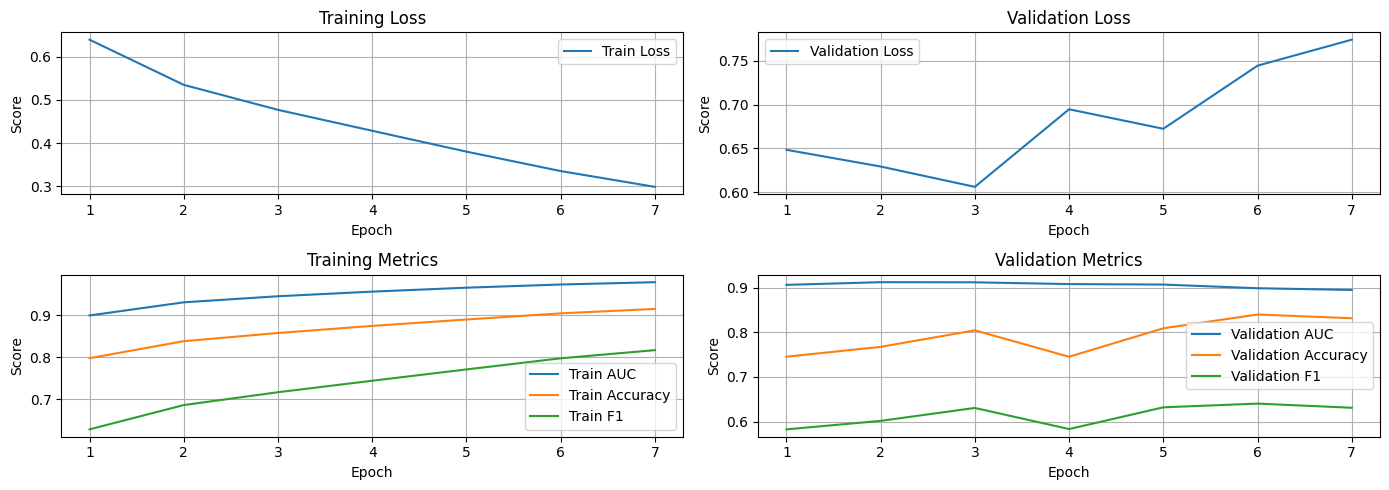

In [170]:
# ÌïôÏäµ Í∑∏ÎûòÌîÑ

# Í≥µÌÜµ ÌîåÎ°Ø Ìï®Ïàò
epochs = range(1, len(train_his_auc) + 1)

def plot_metrics(ax, epochs, metrics, title, labels):
    for metric, label in zip(metrics, labels):
        ax.plot(epochs, metric, label=label)
    ax.set_title(title)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Score')
    ax.legend()
    ax.grid(True)

fig, axes = plt.subplots(2, 2, figsize=(14, 5))

# Í∞Å subplotÏóê ÎÇ¥Ïö© Ï±ÑÏö∞Í∏∞
plot_metrics(
    axes[0][0], epochs,
    [train_his_loss],
    'Training Loss',
    ['Train Loss']
)

plot_metrics(
    axes[0][1], epochs,
    [val_his_loss],
    'Validation Loss',
    ['Validation Loss']
)

plot_metrics(
    axes[1][0], epochs,
    [train_his_auc, train_his_acc, train_his_f1],
    'Training Metrics',
    ['Train AUC', 'Train Accuracy', 'Train F1']
)

plot_metrics(
    axes[1][1], epochs,
    [val_his_auc, val_his_acc, val_his_f1],
    'Validation Metrics',
    ['Validation AUC', 'Validation Accuracy', 'Validation F1']
)

plt.tight_layout()
plt.show()


## Î™®Îç∏ ÌèâÍ∞Ä

In [15]:
def evaluate_binary_classification(y_true, y_pred_probs, threshold=0.5, title="Confusion Matrix"):
    """
    y_true: Ï†ïÎãµ (0 ÎòêÎäî 1)
    y_pred_probs: ÏòàÏ∏° ÌôïÎ•† (0.0 ~ 1.0)
    y_pred: ÏòàÏ∏° ÎùºÎ≤® (0 ÎòêÎäî 1)
    threshold: ÏòàÏ∏° ÌôïÎ•† ‚Üí ÌÅ¥ÎûòÏä§ Î≥ÄÌôò Í∏∞Ï§Ä (Í∏∞Î≥∏Í∞í 0.5)
    """
    y_pred = (y_pred_probs >= threshold).astype(int)
    
    # AUROC
    auc = roc_auc_score(y_true, y_pred_probs)
    print(f"\n‚úÖ AUROC: {auc:.4f}")

    # f1-score
    f1 = f1_score(y_true, y_pred)
    print(f"\n‚úÖ F1-score: {f1:.4f}")

    # ACC
    acc = accuracy_score(y_true, y_pred)
    print(f"\n‚úÖ Accuracy: {acc:.4f}")

    # Classification Report
    print("\nüìä Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))

In [16]:
# beit test ÏÖã ÌèâÍ∞Ä
Dense161.load_state_dict(torch.load("Dense161-4.pt"))
Dense161.eval()                    
y_true = []
y_pred_probs = []
images_all = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        outputs = Dense161(images)
        probs = torch.sigmoid(outputs)

        y_true.extend(labels.cpu().numpy().squeeze())
        y_pred_probs.extend(probs.cpu().numpy().squeeze())
        images_all.extend(images.cpu())

# ÌèâÍ∞Ä Ìò∏Ï∂ú
evaluate_binary_classification(np.array(y_true), np.array(y_pred_probs), threshold=0.6293, title="test Set")


100% 488/488 [00:23<00:00, 20.76it/s]


‚úÖ AUROC: 0.9141

‚úÖ F1-score: 0.6453

‚úÖ Accuracy: 0.8089

üìä Classification Report:
              precision    recall  f1-score   support

         0.0     0.9606    0.7938    0.8693     12476
         1.0     0.5130    0.8697    0.6453      3116

    accuracy                         0.8089     15592
   macro avg     0.7368    0.8317    0.7573     15592
weighted avg     0.8712    0.8089    0.8245     15592



AUROC: 0.9141 | Best Threshold: 0.6293


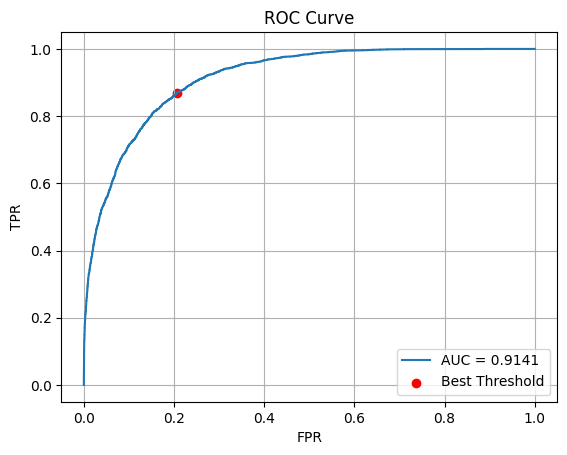

AUPRC: 0.7497


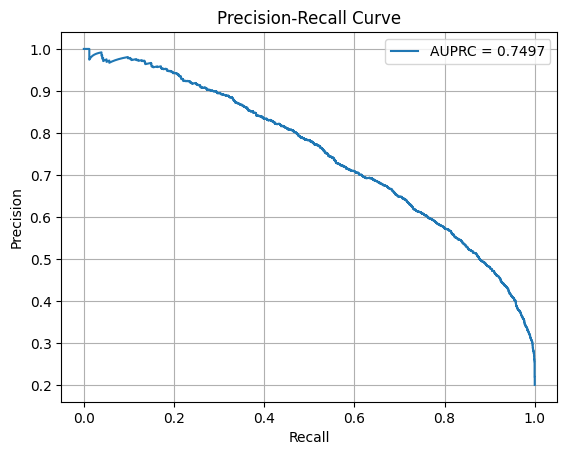

In [21]:
    y_true = np.array(y_true)
    y_probs = np.array(y_pred_probs)

    # üü° AUROC
    fpr, tpr, thresholds = roc_curve(y_true, y_probs) # fpr, tprÏùÑ Í≥ÑÏÇ∞Ìï† Îïå ÏÇ¨Ïö©Ìïú thresholdÎì§ 
    auroc = roc_auc_score(y_true, y_probs)
    youden = tpr - fpr
    best_idx = youden.argmax()
    best_threshold = thresholds[best_idx]
    print(f"AUROC: {auroc:.4f} | Best Threshold: {best_threshold:.4f}")
    
    # üìä ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auroc:.4f}")
    plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label="Best Threshold")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

    # üîµ AUPRC
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    auprc = average_precision_score(y_true, y_probs)
    print(f"AUPRC: {auprc:.4f}")

    plt.figure()
    plt.plot(recall, precision, label=f"AUPRC = {auprc:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid()
    plt.show()


Threshold-wise Performance:
[TH=0.30] Sensitivity: 0.961 | Specificity: 0.617
Confusion Matrix:
[[7701 4775]
 [123 2993]]

[TH=0.50] Sensitivity: 0.919 | Specificity: 0.729
Confusion Matrix:
[[9092 3384]
 [252 2864]]

[TH=0.70] Sensitivity: 0.827 | Specificity: 0.830
Confusion Matrix:
[[10359 2117]
 [539 2577]]

[TH=0.63] Sensitivity: 0.870 | Specificity: 0.794
Confusion Matrix:
[[9904 2572]
 [406 2710]]


Grad-CAM ÏÉòÌîå ÏãúÍ∞ÅÌôî:


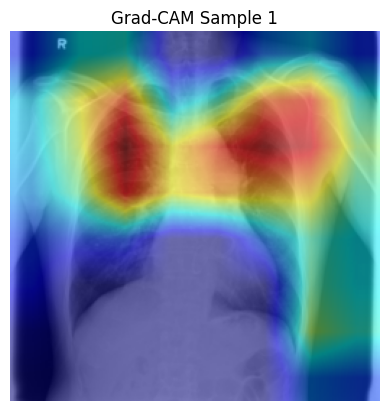

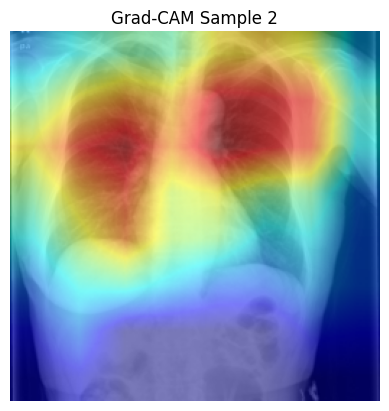

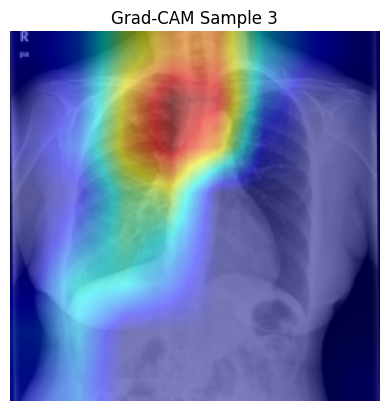

In [35]:
    threshold_list=[0.3, 0.5, 0.7]
    gradcam_samples=3
    # Îã§ÏñëÌïú Threshold
    print("\nThreshold-wise Performance:")
    for th in threshold_list + [best_threshold]:
        y_pred = (y_probs >= th).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        sens = tp / (tp + fn + 1e-8)
        spec = tn / (tn + fp + 1e-8)
        print(f"[TH={th:.2f}] Sensitivity: {sens:.3f} | Specificity: {spec:.3f}")
        print(f"Confusion Matrix:\n[[{tn} {fp}]\n [{fn} {tp}]]\n")

    # GradCAM 
    print("\nGrad-CAM ÏÉòÌîå ÏãúÍ∞ÅÌôî:")
    cam = GradCAM(model=Dense161, target_layers=[Dense161.features[-1]])
    for i in range(min(gradcam_samples, len(images_all))):
        input_tensor = images_all[i].unsqueeze(0).to(device)
        grayscale_cam = cam(input_tensor=input_tensor)[0]
        img = images_all[i].squeeze().numpy()
        rgb_img = np.repeat(img[np.newaxis, :, :], 3, axis=0).transpose(1,2,0)
        rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())
        vis = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
        plt.imshow(vis)
        plt.title(f"Grad-CAM Sample {i+1}")
        plt.axis('off')
        plt.show()